In [91]:
import numpy as np
import pandas as pd
import h5py
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from statistics import mean
import scipy
from pathlib import Path
import math
from scipy.optimize import curve_fit,least_squares,leastsq
from scipy.interpolate import interp1d
from scipy.optimize import Bounds
from scipy.fft import fft, fftfreq
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal 
from scipy.signal import lombscargle
import operator
import matplotlib.ticker as ticker

In [15]:
#Plotting Options
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.style.use('seaborn')

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["font.family"] = "Times New Roman"

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

#make colormap indicating cloud phase
liquid = cm.get_cmap('Reds_r', 60)
mixed = cm.get_cmap('RdPu_r', 90)
ice = cm.get_cmap('PuBu_r', 120)

newcolors = np.vstack((ice(np.linspace(0, .5, 60)),
                       mixed(np.linspace(0, .5, 90)),
                       liquid(np.linspace(0, .5, 120))))
newcmp = ListedColormap(newcolors, name='Phases')

In [16]:
#path to preprocessed dataset
path = 'path'

#choose filepath to desired data
calibration_path = 'calibration_path'

def get_dataset_keys(f):
    keys = []
    f.visit(lambda key : keys.append(key) if isinstance(f[key], h5py.Dataset) else None)
    return keys

a_file = h5py.File(path+ 'data.h5', "r")
print(a_file.keys())
a_file.close()

<KeysViewHDF5 ['angles', 'nedt', 'responses1', 'responses2', 'responses_err1', 'responses_err2', 'var', 'var1', 'var2', 'waves']>


# Import Calibration Data

Import hdf5 data generated from calculate_POL 

In [97]:
with h5py.File(path+ 'data.h5', "r") as file:
    waves = file['/waves'][()]
    measurement = file['/angles'][()]
    
    R1 = file['/responses1'][()] +50
    R2 = file['/responses2'][()] +50
    
    E1 = file['responses_err1'][()]
    E2 = file['responses_err2'][()]

## Import Spectral Calibration Data

In [18]:
a_file = h5py.File(calibration_path+ 'calibration.h5', "r")
print(a_file.keys())
a_file.close()

<KeysViewHDF5 ['polarization', 'radiometric']>


In [20]:
with h5py.File(calibration_path+ 'calibration.h5', "r") as file:
    lambda_c = file['/pixel/wavelength'][()]
    pixel1 = file['/pixel/pixel1'][()]
    pixel2 = file['/pixel/pixel2'][()]

## Import AOLP dependent transmission

This function will correct for differences in transmission over a single period

In [22]:
def transmission_correction(I1,I2,iterations):
    T = 1
    i = 0
    while i < iterations:
        t = np.mean(I1)/np.mean(I2)
        T_update = T*t
        I2_update = t*I2
        I2 = I2_update
        T= T_update
        i = i+1;
    return([I1,I2])

In [23]:
def MOD(a,band):
#calculate modulation function for calibration data
    i = band

    start = pixel1[i]
    stop  = pixel2[i]
    I1 = R1[a,start:stop]
    I2 = R2[a,start:stop]
    
    e1 = E1[a,start:stop]
    e2 = E2[a,start:stop]
    
    I1,I2 = transmission_correction(I1,I2,15)

    mod_a = (I1-I2)/(I1+I2)
                            
    I1e = e1
    I2e = e2

    mod_a = (I1-I2)/(I1+I2)
    mod_e = (e1+e2)/(I1+I2)
                            
    return([mod_a,mod_e])

## periodogram

In [27]:
from astropy.timeseries import LombScargle
wavenums = np.divide(1,np.multiply(lambda_c,1e-4))

with h5py.File(calibration_path+ 'calibration.h5', "r") as file:
    carrier = file['/polarization/carrier'][()]
    W = file['/polarization/W'][()]
    W_ang = file['/polarization/W_ang'][()]
    phase = file['/polarization/phase'][()]
    wavenums = file['/polarization/wavenums'][()]

0.005975495427683511


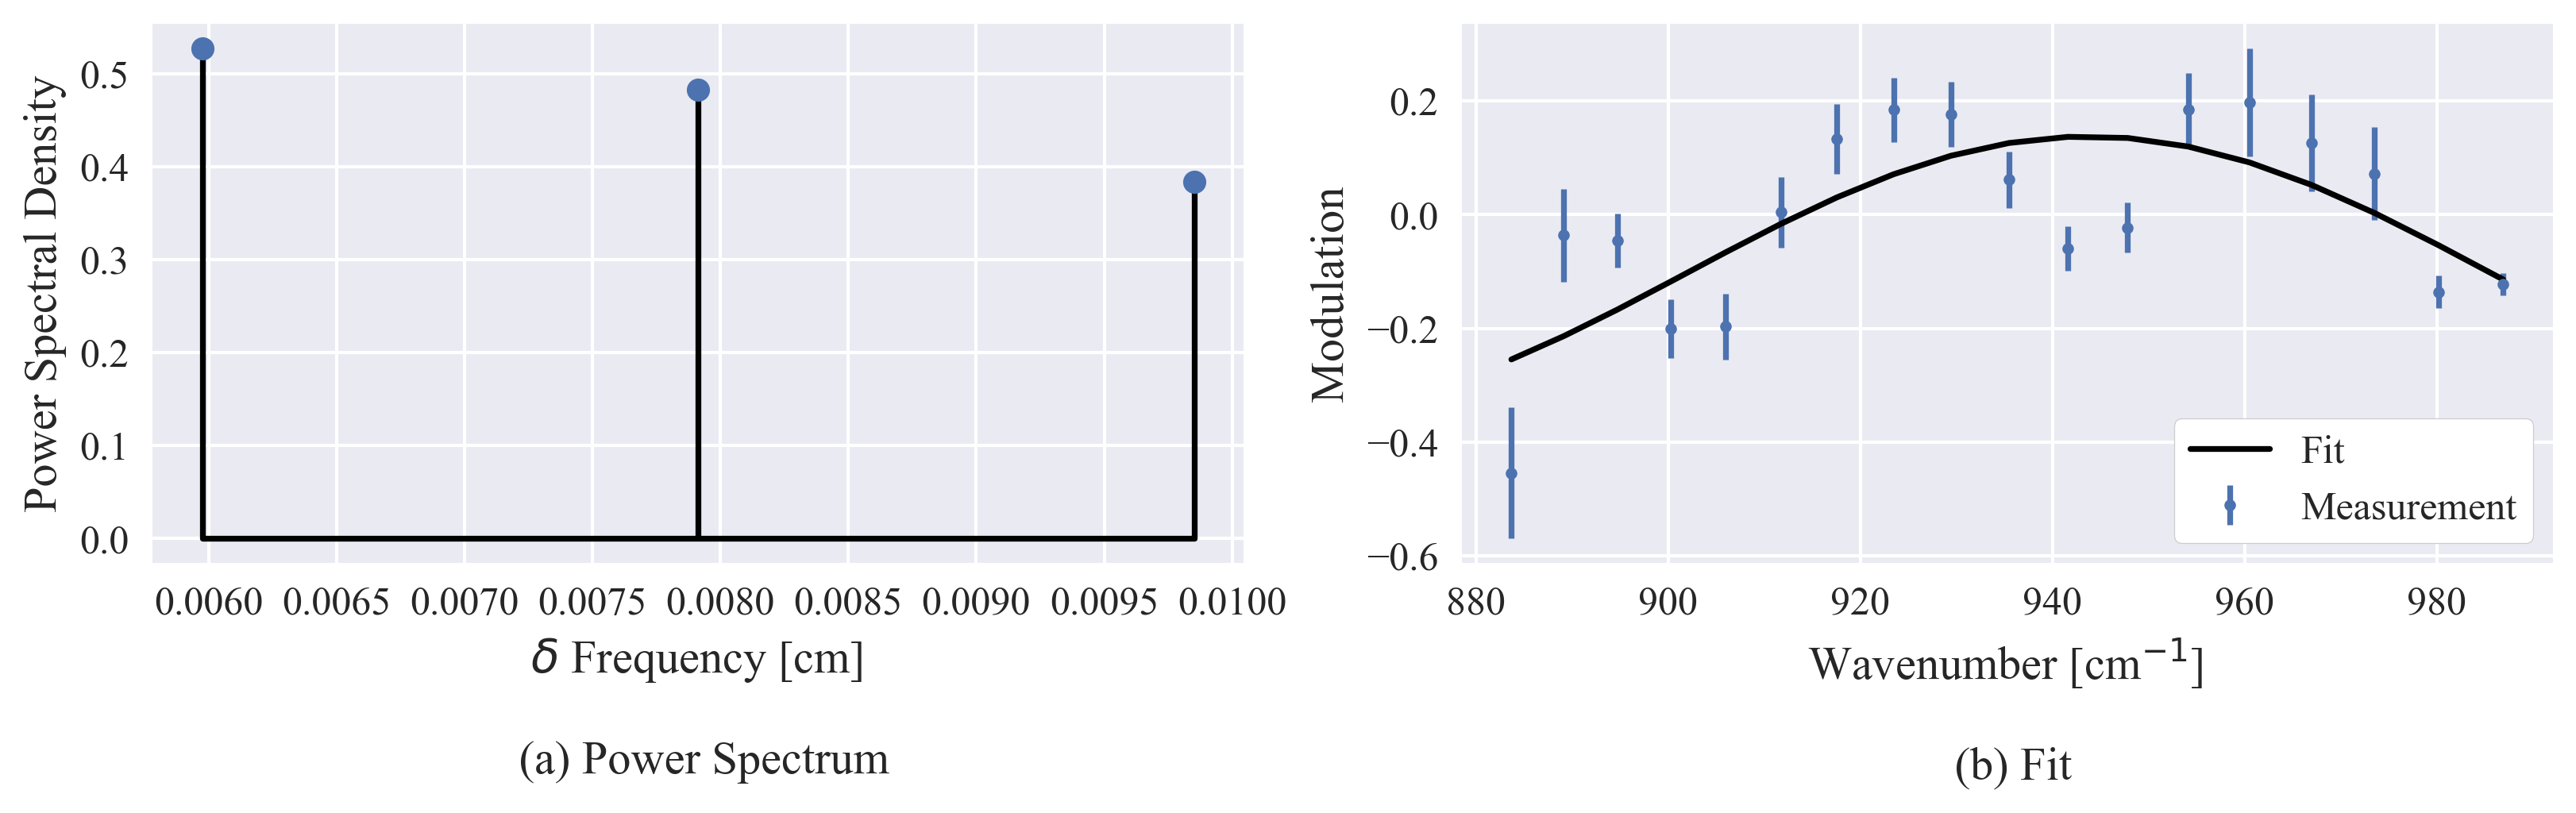

In [31]:
a = 1500
j = 49
start = pixel1[j]
stop  = pixel2[j]
n = stop-start;

x = wavenums[start:stop]
[y,dy] = MOD(a,j)

start = pixel1[j] #first pixel 
stop  = pixel2[j] #last pixel 
n = stop-start;

ls = LombScargle(x, y)
frequency,power = LombScargle(x, y).autopower(minimum_frequency=carrier[j]-.002,
                                    maximum_frequency=carrier[j]+.002) #sampling in 1 period intervalsLombScargle(x, y,dy)

best_frequency = frequency[np.argmax(power)]
t_fit = x
y_fit = ls.model(t_fit, best_frequency)

[offset,u,q] = ls.model_parameters( best_frequency)
print(best_frequency)

fig, axes = plt.subplots(1,2,figsize=(13, 3))
plt.gcf().set_dpi(300)
axes[0].stem(frequency, power, 'k',basefmt = 'k')
axes[0].set_xlabel('$\delta$ Frequency [cm] \n \n (a) Power Spectrum')
axes[0].set_ylabel('Power Spectral Density')     

axes[1].plot(t_fit,y_fit,'k', label='Fit')
axes[1].set_xlabel('Wavenumber [cm$^{-1}$] \n \n (b) Fit')
axes[1].set_ylabel('Modulation')
axes[1].errorbar(x,y,yerr = dy,fmt='.', label='Measurement')
legend = plt.legend(framealpha=1, frameon=True)
legend.get_frame().set_facecolor('w')
plt.show()

In [32]:
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return idx

def LombModel_corr(a,j,thresh):
    start = pixel1[j]
    stop  = pixel2[j]
    n = stop-start;
    freq = carrier[j]

    x = wavenums[start:stop] #select mod period
    [y,dy] = MOD(a,j)
 

    ls = LombScargle(x, y)
    frequency, power = ls.autopower(minimum_frequency=carrier[j]-.002,
                                    maximum_frequency=carrier[j]+.002) #sampling in 1 period intervalsLombScargle(x, y,dy)
    
    best_frequency = frequency[np.argmax(power)]
    prob = ls.false_alarm_probability(power[np.argmax(power)])  
    if prob < thresh:
        [offset,u,q] = ls.model_parameters(freq)
        dolp = (((u)**2 +(q)**2)**0.5)
        aolp = 0.5*np.arctan2(u,q)
        aolp_corr = aolp - phase[j]
        idx = find_nearest(W_ang, aolp_corr )
        eff = W[j,idx]
        dolp_corr = dolp/(100*eff)
        if dolp_corr > 1:
            [prob,u,q,dolp_corr,aolp_corr] =[np.NAN,np.NAN,np.NAN,np.NAN,np.NAN]
            
    else:
        [prob,u,q,dolp_corr,aolp_corr] =[np.NAN,np.NAN,np.NAN,np.NAN,np.NAN]
    
    return([dolp_corr,aolp_corr,prob])

## Demodulate Data

In [2]:
#Choose size of arrays to match teh length of your data set

In [157]:
dolp = np.zeros([0,100])
aolp = np.zeros([0,100])
prob = np.zeros([0,100])
for j in range(5,49): #j is the index of wavelengths to process
    for a in range([0,100]):
        try:
            out = LombModel_corr(a,j,.3)  
            dolp[j,a]=out[0]
            aolp[j,a]=out[1]
            prob[j,a]=out[2]
        except:
            dolp[j,a]=np.nan
            aolp[j,a]=np.nan
            prob[j,a]=np.nan
    

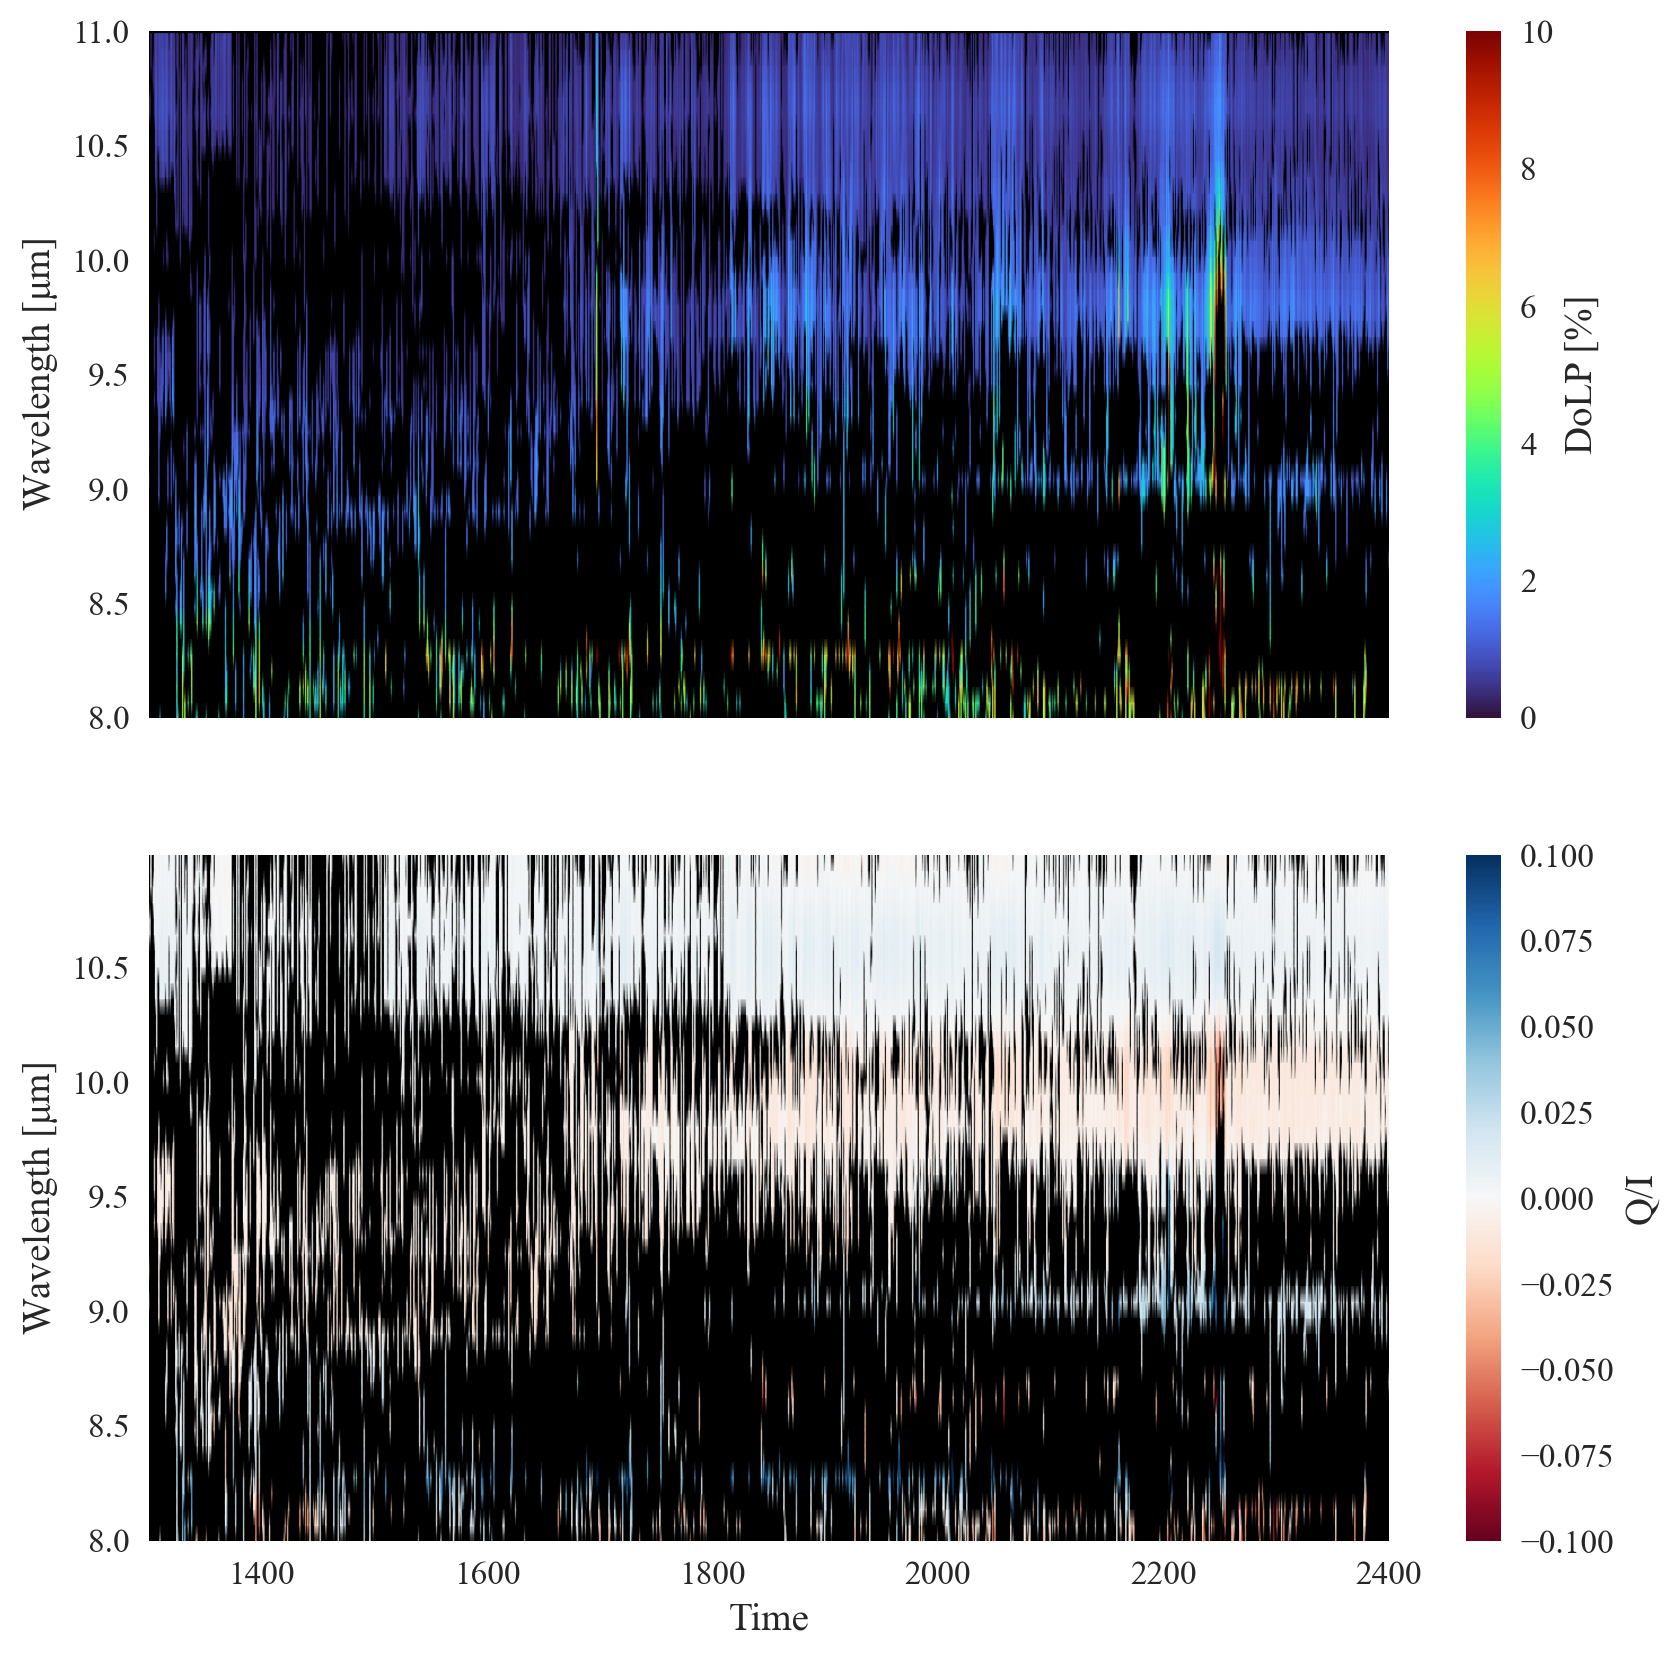

In [148]:
#plot test images, test appearance
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10),sharex = True)
X,Y = np.meshgrid(np.linspace(1300,2400,1100),lambda_c[5:49])

im1 = axes[0].pcolormesh(X,Y,dolp*100,cmap = 'turbo',vmin = 0,vmax = 10 ,shading = 'gouraud' )
axes[0].set_ylim(8,11.0)
axes[0].set_facecolor('xkcd:black')
axes[0].set_ylabel('Wavelength [$\mathdefault{\mu}$m]') 
fig.colorbar(im1,ax = axes[0],label = 'DoLP [%]')

im2 = axes[1].pcolormesh(X,Y,dolp*np.cos(2*aolp),cmap = 'RdBu',vmin = -.1,vmax = .1 ,shading = 'gouraud'  )
fig.colorbar(im2,ax = axes[1],label = 'Q/I')
axes[1].set_facecolor('xkcd:black')
axes[1].set_xlabel('Time') 
axes[1].set_ylabel('Wavelength [$\mathdefault{\mu}$m]') 
plt.gcf().set_dpi(200)
plt.show()

# Radiometric Calculation

In [37]:
from radiometric.LUT import create_LUT_df, determine_reference, applyNUC_to_LUT

from NUC.NUC_functions import import_NUC, apply_NUC, get_slice, determine_slope
from NUC.NUC_functions import determine_dark, apply_DFC_to_df
from NUC.NUC_functions import pixel_registration

from matplotlib import cm
from scipy.optimize import curve_fit
import matplotlib.colors as colors


In [38]:
""" Fitting Function"""
def func(x, a, b):
    y = (x/a)**0.25 +b
    return y

In [49]:
with h5py.File(calibration_path+ 'calibration.h5', "r") as file:
    nedt = file['/radiometric/nedt'][()]
    var = file['/radiometric/var'][()]

In [95]:
def get_BT(j,i,f):
    bt = []
    Et = []
    for a in range(i,f):
        start = pixel1[j]
        stop  = pixel2[j]

        response = np.sum(R1[a,start:stop]+R2[a,start:stop])
        response_err = np.sum(E1[a,start:stop]+E2[a,start:stop])
        bt.append(func(response,var[j,0],var[j,1]))
        Et.append(func(response+response_err/2,var[j,0],var[j,1])-func(response-response_err/2,var[j,0],var[j,1]))
    return([bt,Et])


In [73]:
df_ircsp = pd.read_csv("/Users/kirahart/Dropbox/Research/balloon/telemetry_data/IRCSP_TELEMETRY.csv")
times = []
alt = []
a = .4

for i in range(len(df_ircsp)):
    tt = df_ircsp['datetime'].loc[i]
    alt.append(df_ircsp['pressure'].loc[i])
    times.append(tt[11:16])

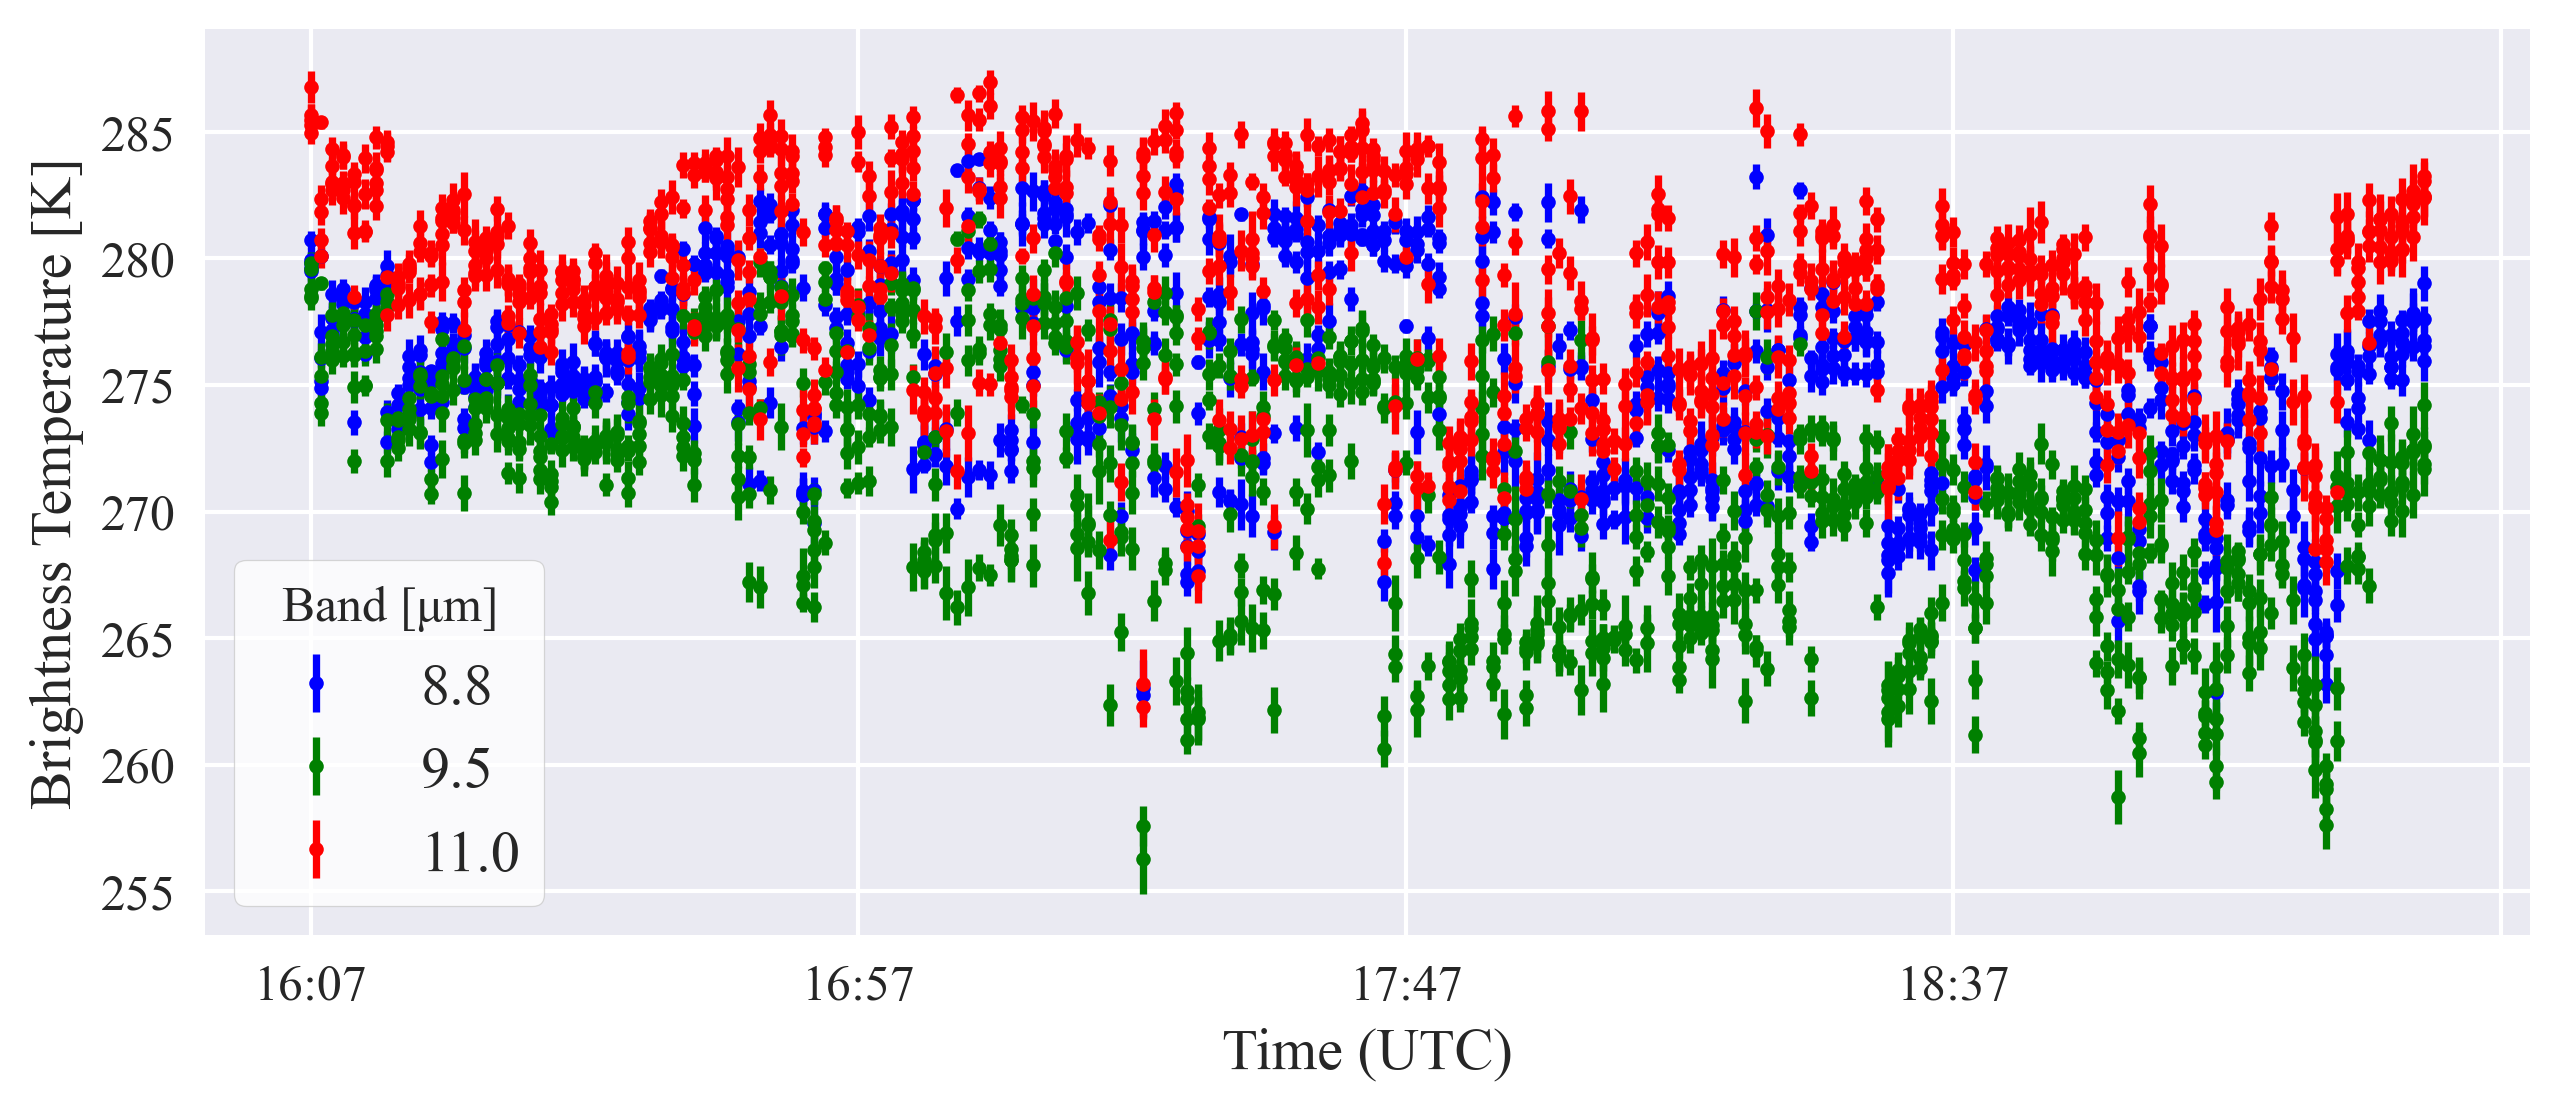

In [154]:
ii = 1300
ff = 2300

[bt1,et1] = get_BT(17,ii,ff)
[bt2,et2] = get_BT(26,ii,ff)
[bt3,et3] = get_BT(35,ii,ff)
tt = len(times)-len(bt1)
fig1, ax = plt.subplots(1,1,figsize = (10,4),dpi = 500)
plt.gcf().set_dpi(300)
plt.errorbar(times[tt:],bt1,yerr = np.divide(et1,1),fmt = '.',label = "8.8",c = 'blue')
plt.errorbar(times[tt:],bt2,yerr = np.divide(et2,1),fmt = '.',label = "9.5",c = 'green')
plt.errorbar(times[tt:],bt3,yerr = np.divide(et2,1),fmt = '.',label = "11.0",c = 'red')
plt.legend(fontsize = 14,title = 'Band [$\mathdefault{\mu}$m]',facecolor="white",frameon=True)
plt.ylabel("Brightness Temperature [K]")
plt.xlabel('Time (UTC)')
ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
plt.grid(True)
plt.show()
